In [4]:
from ast import arg, parse
import os
import time
import datetime as dt
from pathlib import Path
from argparse import ArgumentParser, BooleanOptionalAction

from matplotlib import axis

from model import Model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.classification import Dice, MulticlassJaccardIndex,MulticlassF1Score

import wandb
from numpy import argmax, dtype, mean
from tqdm import tqdm


from DataLoader import * # , calculate_mean
from utils import LABELS, map_id_to_train_id, train_id_to_name
from DataVisualizations import visualize_criterion, transform_tensor_to_class_color
from train import get_arg_parser

# Define the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
parser = get_arg_parser()
args = parser.parse_known_args()[0]
train_loader, val_loader = generate_data_loaders(args)
imgs, masks = next(iter(train_loader))

In [19]:
img_int = random.randrange(0,len(imgs))
img = imgs[img_int]
mask = masks[img_int]

In [20]:
mask.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=torch.uint8)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=torch.uint8)


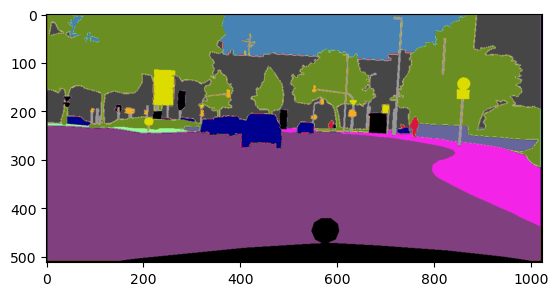

In [22]:
import matplotlib.pyplot as plt
plt.imshow(
transform_tensor_to_class_color(mask,False)
)

print(mask.unique())

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 19],
       dtype=torch.uint8)


tensor(30, dtype=torch.uint8)

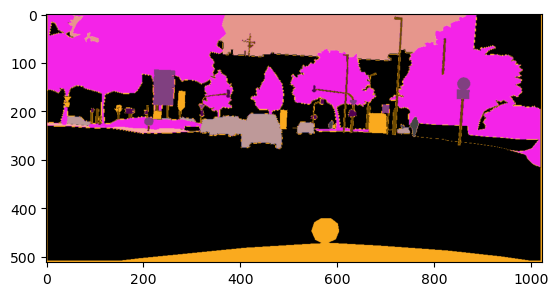

In [24]:
plt.imshow(transform_tensor_to_class_color(
    map_id_to_train_id(mask),trainId = False))

print(map_id_to_train_id(mask).unique())
mask.max()

In [16]:
mask.max()

tensor(38, dtype=torch.uint8)

In [ ]:
import PIL
fig, axs = plt.subplots(len(LABELS), figsize=(5, len(LABELS)*2))
converted_mask = map_id_to_train_id(mask)
im = PIL.Image.new(mode="RGB", size=(mask.shape[2], mask.shape[1]))

for i, label in enumerate(LABELS):
    # im = PIL.Image.new(mode="RGB", size=(mask.shape[2], mask.shape[1]))
    im = np.array(im)
    im[converted_mask.squeeze() == label.trainId] = label.color
    axs[i].imshow(im)
    axs[i].set_title(label.name)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

### Debug cross entropy

In [10]:
# setup
criterion = nn.CrossEntropyLoss(reduction='none')

batch_size = 2
nb_classes = 4

# output = torch.randn(batch_size, nb_classes)
# target = torch.randint(0, nb_classes, (batch_size,))
# loss = criterion(output, target)

# # manual calculation
# loss_manual = 0.
# for idx in range(output.size(0)):
#     # get current logit from the batch
#     logit = output[idx]
    
#     # get target from the batch
#     t = target[idx]
    
#     loss_manual += -1. * logit[t] + torch.log(torch.sum(torch.exp(logit)))

# # calculate mean loss
# loss_elements = output.size(0)
# loss_manual = loss_manual / loss_elements
# print(torch.allclose(loss, loss_manual))
# print(loss_manual)

# for segmentation
h, w = 4, 4
output = torch.randn(batch_size, nb_classes, h, w)
target = torch.randint(0, nb_classes, (batch_size, h, w,))
loss = criterion(output, target)

# manual calculation
loss_manual = 0.
for idx in range(output.size(0)):
    for h_ in range(h):
        for w_ in range(w):
            # get current logit from the batch
            logit = output[idx, :, h_, w_]
            
            # get target from the batch
            t = target[idx, h_, w_]
            
            loss_manual += -1. * logit[t] + torch.log(torch.sum(torch.exp(logit)))

# calculate mean loss
loss_elements = (output.size(0) * output.size(2) * output.size(3))
loss_manual = loss_manual / loss_elements
print(torch.allclose(loss, loss_manual))
print(loss_manual)
print(loss)


False
tensor(1.9668)
tensor([[[0.7943, 1.6409, 5.2050, 3.1080],
         [1.4397, 0.3754, 1.2775, 1.0276],
         [1.3160, 2.0397, 0.2923, 3.3472],
         [2.1655, 1.5182, 3.6524, 1.3505]],

        [[1.9725, 1.3062, 2.2361, 2.2750],
         [3.3125, 1.7505, 0.4629, 2.6377],
         [3.3197, 1.1238, 3.0565, 1.2711],
         [3.3739, 1.2368, 0.4717, 2.5797]]])


In [12]:
output.backward()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn